In [48]:
%matplotlib inline
import pandas as pd
import numpy as np
import psycopg2
import matplotlib.pyplot as pp
import pylab as pl
import folium
from IPython.display import HTML
import seaborn as sns
from scipy import stats


HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

In [4]:
result = pd.read_excel('/Users/ryan/Desktop/may12_portaldata.xlsx', encoding= 'utf-8-sig')

result['hh_size_hhinfo'] = pd.to_numeric(result['hh_size_hhinfo'], errors='coerce')

result.loc[result['incomplete'] == 0, 'complete'] = 1
result.loc[result['refusal'] == 1, 'complete'] = 0
result.loc[result['perm_unavail'] == 1, 'complete'] = 0

In [5]:
counts = result[['state_name','dist_name','refusal','incomplete','complete', 'perm_unavail']].groupby(['state_name','dist_name']).sum()
counts['Total Attempted'] = result[['state_name','dist_name','dod_enumerator_id_intro']].groupby(['state_name','dist_name']).count()
counts['% Refusal'] = ((counts['refusal'] / counts['Total Attempted']))
counts['% Incomplete'] = ((counts['incomplete'] / counts['Total Attempted']))
counts['% Unavailable'] = ((counts['perm_unavail'] / counts['Total Attempted']))
counts = counts.drop(columns=['refusal', 'incomplete','perm_unavail'])
counts = counts[['% Refusal','% Unavailable', '% Incomplete','complete','Total Attempted']]

(counts.loc[:]
    .style
    .format({'% Refusal': "{:.1%}", '% Unavailable': "{:.1%}",'% Incomplete': "{:.1%}"})
    .background_gradient(cmap='RdBu', low=0, high=0.2,subset=['complete', 'Total Attempted'])
    .background_gradient(cmap='coolwarm', low=0.5, high=0.1,subset=['% Refusal', '% Incomplete', '% Unavailable']))

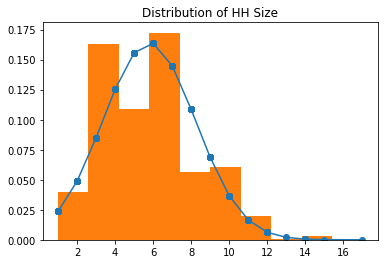

In [49]:
h = sorted(result['hh_size_hhinfo'].dropna())  #sorted

fit = stats.norm.pdf(h, np.mean(h), np.std(h))  #this is a fitting indeed

pl.plot(h,fit,'-o')
pl.hist(h,normed=True)
pl.title("Distribution of HH Size")
pl.show()  

In [9]:
a = result.gps_location_end.str.split(' ').dropna()
b = pd.DataFrame((item for item in a), columns = ['lat','long','alt','acc'])
b['lat'] = pd.to_numeric(b['lat'], errors='coerce')
b['long'] = pd.to_numeric(b['long'], errors='coerce')
b['ref'] = result['refusal']
b['comp'] = result['incomplete']

In [46]:
lat = b['lat'].values
lon = b['long'].values
colors = {1 : 'red', 0 : 'blue'}

url_base = 'http://server.arcgisonline.com/ArcGIS/rest/services/'
service = 'NatGeo_World_Map/MapServer/tile/{z}/{y}/{x}'
tileset = url_base + service


map_osm = folium.Map(location=[26.222534, 82],zoom_start=5, control_scale = True, tiles=tileset, attr='USGS style')

#folium.LayerControl().add_to(map_osm)
for row in b.itertuples():
    map_osm.add_child(folium.CircleMarker(location=[row.lat, row.long], radius=1,color=colors[row.comp], 
                                                      prefix='fa'))

legend_html =   '''
                <div style="position: fixed; 
                            background-color:white;
                            bottom: 450px; left: 50px; width: 125px; height: 50px; 
                            border:2px solid grey; z-index:9999; font-size:14px;
                            ">&nbsp; Incomplete &nbsp; <i class="fa fa fa-circle" style="color:red"></i><br>
                              &nbsp; Complete &nbsp; <i class="fa fa fa-circle" style="color:blue"></i>   
                </div>
                ''' 
map_osm.get_root().html.add_child(folium.Element(legend_html)).add_child(folium.Element("<h1>Submitted Forms Mapped by GPS</h1>"))
map_osm